# Домашняя работа 2. Логистическая регрессия.

### Оценивание и штрафы

Максимальная оценка — 10 баллов. 

Не списывайте, иначе всем участникам обнулим :)

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка: 10**

In [3]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Часть 1. Логрег своими руками (5.5 балла)

**Задание 1 (8 баллов)**. Реализуйте логистическую регрессию, обучаемую с помощью:
- градиентного спуска **(4 балла)**

- стохастического градиентного спуска **(4 балла)**

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска;
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавим атрибут класса `loss_history`. В нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

*Комментарий:* Я ввел два дополнительных параметра модели - batch_size и curr_batch_index, чтобы хранить размер батча и индекс его начального элемента. Если `gd_type='full'`, то каждый раз выбирается индекс 0 и вся выборка в качестве размера батча. 

Функция копирует и перемешивает данные.

Формулу градиента выбрал другую (без $1/n$ в начале), чтобы он не зависел от размера выборки, но лосс считается стандартно.

Также написал дополнительно функцию `get_loss_hist`

В остальном все как обычно.

In [304]:
from sklearn.base import BaseEstimator
from sklearn.utils import shuffle

class LogReg(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-4, 
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None, batch_size = None) -> None:
        """
        Args:
          gd_type: Type of gradient descent ('full' or 'stochastic'). 
          
          tolerance: Threshold for stopping gradient descent.
          
          max_iter: Maximum number of steps in gradient descent.
          
          eta: Learning rate.
          
          w0: Array of shape d (d — number of weights to optimize).
              Initial weights.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None
        self.batch_size = batch_size
        self.curr_batch_index = 0
    
    def fit(self, X: np.array, y: np.array) -> LogReg:
        """Fit the model on training data. Also, save value of loss after each iteration.
        
        Args:
          X: Training data.
          
          y: Target.
        
        Returns: 
          self: Fitted classsifier.  
        """
        self.loss_history = []
        if self.w0 is None: self.w0 = np.ones(X.shape[1]) #if the start is not specified, start at ones
        if self.batch_size is None: 
            if self.gd_type == 'stochastic': self.batch_size = min(X.shape[0], 32)
            else: self.batch_size = X.shape[0]

        self.w = self.w0
        X_, y_ = shuffle(X, y)
        self.loss_history.append(self.calc_loss(X, y))

        for _ in range(self.max_iter):
            
            if self.gd_type == 'stochastic':
                X_ = X_[self.curr_batch_index : self.curr_batch_index + self.batch_size]
                y_ = y_[self.curr_batch_index : self.curr_batch_index + self.batch_size]
                self.curr_batch_index += self.batch_size
                if self.curr_batch_index + self.batch_size >= X_.shape[0]: self.curr_batch_index = 0
                grad = self.calc_gradient(X_, y_)

            else: grad = self.calc_gradient(X_, y_)
            
            self.w -= self.eta * grad
            self.loss_history.append(self.calc_loss(X, y))
            if np.linalg.norm(self.eta * grad) < self.tolerance:
                break
        return self
    
    
    def predict_proba(self, X: np.array) -> np.array:
        """Calculate probability of positive and negative class for each observation.
        
        Args:
          X: Array of shape (n, d).
             Data.
        
        Returns: 
             Array of shape (n, 2).
             Predicted probabilities.
        """
        sigma = lambda x: 1 / (1 + np.e**(-x))
        return sigma(X.dot(self.w))
    
    
    def predict(self, X: np.array) -> np.array:
        """Predict class for each observation.
        
        Args:
          X: Array of shape (n, d).
             Data.
        
        Returns: 
             Array of shape (n,).
             Predicted class labels.  
        """
        sigma = lambda x: 1 / (1 + np.e**(-x))
        return (sigma(X.dot(self.w)) > 0.5).astype(int)
    
    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Calculate gradient of loss function after each iteration.
        
        Args:
          X: Array of shape (n, d), n can be equal to 1 if 'stochastic'.
          y: Array of shape (n,).
        
        Returns:
          Array of shape (d,).
          Gradient of loss function after current iteration.
        """
        sigma = lambda x: 1 / (1 + np.e**(-x))
        return - 1 / X.shape[0] * (X * (y[:, np.newaxis] - sigma(X.dot(self.w))[:, np.newaxis])).sum(axis=0)

    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Calculate value of loss function after each iteration.
        
        Args:
          X: Array of shape (n, d).
          y: Array of shape (n,).
        
        Returns:
          Value of loss function after current iteration.
        """ 
        sigma = lambda x: 1 / (1 + np.e**(-x))
        return - 1 / X.shape[0] * np.sum(y * np.log(sigma(X.dot(self.w))) + (1 - y) * np.log(sigma(-X.dot(self.w))))
    
    def get_loss_hist(self) -> List[int]:
        return self.loss_history

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Далее мы бы всем советовали использовать готовые реализации методов из sklearn.

Сгенерируем синтетические данные.

In [305]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Задание 2 (1 балл).** Обучите логистическую регрессию на синтетических данных. Нарисуйте кривую обучения.

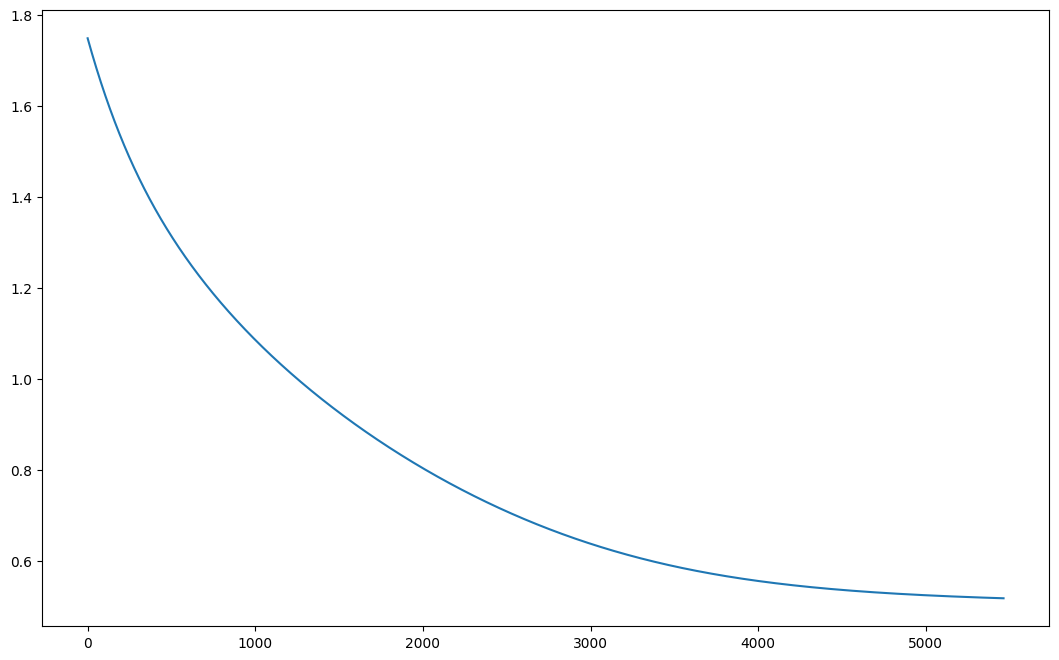

In [306]:
logreg = LogReg(max_iter=10000, eta=1e-3, gd_type='stochastic', tolerance=1e-4, batch_size=100)
logreg.fit(X_train, y_train)

fig, ax = plt.subplots(figsize = (13, 8))
ax.plot(logreg.get_loss_hist())

*Комментарий:* далее я построил матрицу ошибок на своей модели и модели из `sklearn` для сравнения. Оказалось, что модели предсказывают примерно с одинаковой точностью.

In [307]:
from sklearn.metrics import confusion_matrix
y_pred = logreg.predict(X_test)
print(confusion_matrix(y_test, y_pred))
y_pred_proba = logreg.predict_proba(X_test)

[[1200  283]
 [ 442 1075]]


In [308]:
from sklearn.linear_model import LogisticRegression
sklogreg = LogisticRegression()
sklogreg.fit(X_train, y_train)
y_pred = sklogreg.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[1145  338]
 [ 348 1169]]


На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые.

*Комментарий:* кривая PR выглядит странно, так как при некоторых значениях параметра `thresholds` `tp` и `fp` становятся 0, в результате чего `precision` присваивается значение 1. Далее `fp` становится положитльным и `precision` обнуляется. А дальше все становится нормально. В статье прочитал, что такой вид графика - это ОК (https://github.com/tensorflow/tensorboard/issues/444).

ROC UAC: 0.8396789632090522, PR AUC: 0.7792785809178148


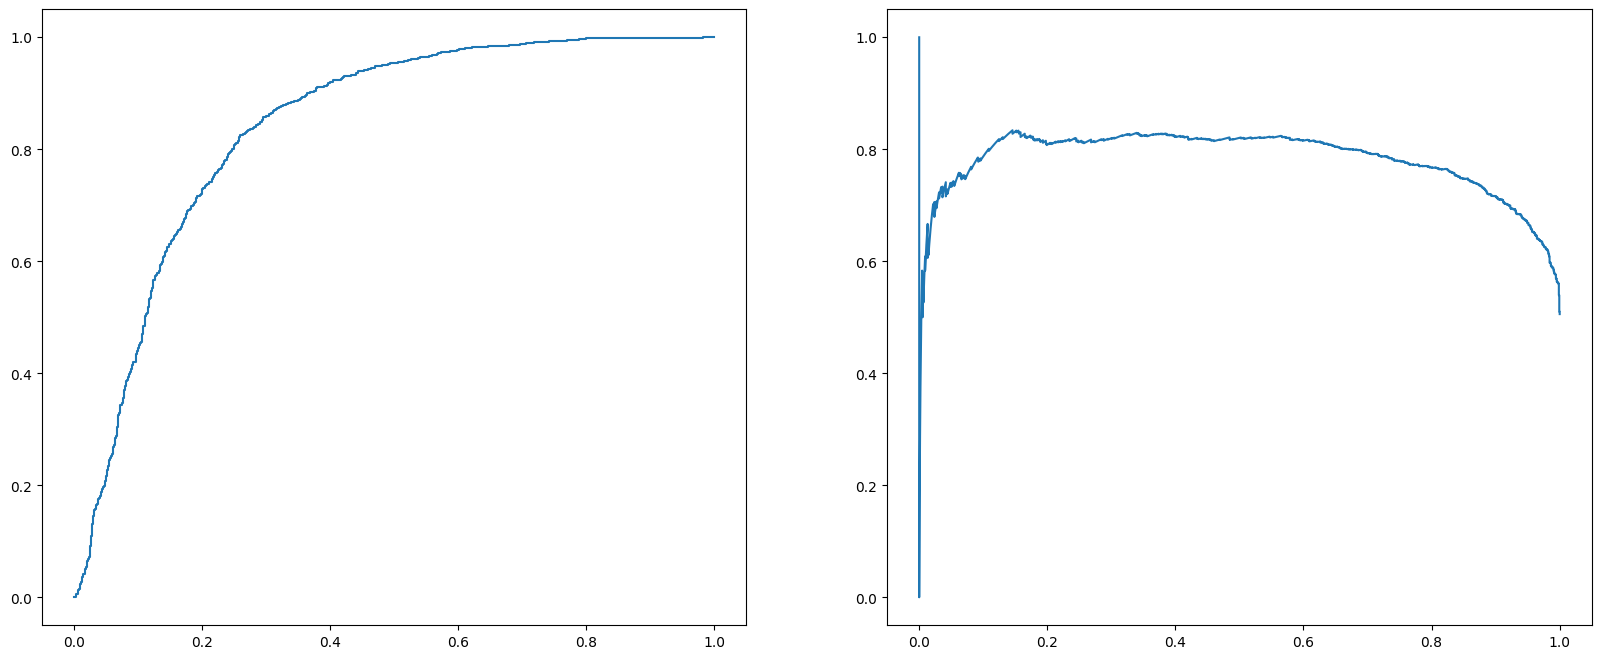

In [309]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc


y_score = logreg.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
prec, rec, _ = precision_recall_curve(y_test, y_score)
fig, axs = plt.subplots(1, 2, figsize = (20, 8))
print(f'ROC UAC: {auc(fpr, tpr)}, PR AUC: {auc(rec, prec)}')
axs[0].plot(fpr, tpr)
axs[1].plot(rec, prec)

**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс валидации.  

In [310]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve


roc_auc_scores = []
pr_auc_scores = []
kf = KFold(n_splits=5)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    logreg.fit(X_train, y_train)
    y_score = logreg.predict_proba(X_test)
    roc_auc_scores.append(roc_auc_score(y_test, y_score))
    prec, rec, threshholds = precision_recall_curve(y_test, y_score)
    pr_auc_scores.append(auc(rec, prec))


print(f'Mean ROC AUC: {np.mean(roc_auc_scores)}, St. Dev. ROC AUC: {np.std(roc_auc_scores)}')
print(f'Mean PR AUC: {np.mean(pr_auc_scores)}, St. Dev. PR AUC: {np.std(pr_auc_scores)}')



Mean ROC AUC: 0.8426035231229093, St. Dev. ROC AUC: 0.00483526866988729
Mean PR AUC: 0.7973001559501758, St. Dev. PR AUC: 0.012536464792019366
